In [ ]:
import sys

sys.path.append("../")

In [88]:
from pathlib import Path
from typing import Callable, Dict, Optional

import gymnasium as gym
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import tqdm
import xopt
from gymnasium.wrappers import RescaleAction, TimeLimit
from xopt.vocs import VOCS

from src.environments import ea
from src.trial import Trial, load_trials
from src.wrappers.tqdm_wrapper import TQDMWrapper
from src.xopt_helper import (
    BOXoptCompatibleWrapper,
    ProximalEIGenerator,
    ProximalUCBGenerator,
    XoptAgent,
    prepare_ARES_EA_data,
)


In [ ]:
trials = load_trials(Path("../data/trials.yaml"))

In [3]:
vocs = VOCS(
    variables={
        "q1": [-72, 72],
        "q2": [-72, 72],
        "cv": [-6.1782e-3, 6.1782e-3],
        "q3": [-72, 72],
        "ch": [-6.1782e-3, 6.1782e-3],
    },
    # objectives={"mae": "MINIMIZE"},
    objectives={"logmae": "MINIMIZE"},
    # constraints={"max_pos": ["LESS_THAN", 2e-3], "max_size": ["LESS_THAN", 2e-3]},
    # constraints={"max_beamparam": ["LESS_THAN", 2e-3]},
    # constraints={"con1": ["GREATER_THAN", 0.5]},
)


In [63]:
trial = trials[0]
max_steps = 75
# Create the environment
env = ea.TransverseTuning(
    backend="cheetah",
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
    },
    action_mode="direct",
    magnet_init_mode=np.array([10, -10, 0, 10, 0]),
    target_beam_mode=trial.target_beam,
)
env = TimeLimit(env, max_steps)
env = TQDMWrapper(env)
env = BOXoptCompatibleWrapper(env, prepare_ARES_EA_data)

# xopt_agent = XoptAgent(env, vocs, action_order=["q1", "q2", "cv", "q3", "ch"], beta=2.0, proximal_weights=1)


In [64]:
output, info = env.reset()
init_magnet_values = env.unwrapped.backend.get_magnets()
init_sample = [
    {k: v for k, v in zip(["q1", "q2", "cv", "q3", "ch"], init_magnet_values)}
]

xopt_agent = XoptAgent(
    env,
    vocs,
    action_order=["q1", "q2", "cv", "q3", "ch"],
    beta=2.0,
    proximal_weights=0.2,
    max_travel_distances=[0.1, 0.1, 0.1, 0.1, 0.1],
)
# Add initial sample
xopt_agent.add_data(pd.DataFrame(init_sample), output)
done = False
while not done:
    action = xopt_agent.predict(n_samples=1)
    output, reward, done, truncated, info = env.step(action)
    xopt_agent.add_data(xopt_agent.last_sample, output)
    # print(output)


100%|██████████| 100/100 [01:08<00:00,  1.46it/s]


In [65]:
xopt_agent.xopt.data

,q1,q2,cv,q3,ch,mae,logmae,max_beamparam
1,10.000000,-10.000000,0.000000,10.000000,0.000000,0.000558,-7.490718,0.001560
2,13.784480,-11.067876,0.000267,6.283411,0.000252,0.000697,-7.268449,0.001899
3,8.233305,-10.421243,0.000265,5.845401,0.000250,0.000397,-7.832655,0.001296
4,0.382294,-10.574299,0.000317,4.512196,0.000299,0.000323,-8.038557,0.000769
5,1.554408,-9.572291,0.000555,3.196865,0.000455,0.000414,-7.789349,0.000809
...,...,...,...,...,...,...,...,...
72,5.323974,-14.371538,-0.000330,17.394671,0.000412,0.000033,-10.318524,0.000064
73,5.628991,-14.785552,-0.000340,17.880069,0.000405,0.000041,-10.096327,0.000062
74,5.393343,-14.526537,-0.000327,18.826192,0.000415,0.000037,-10.208486,0.000066
75,5.527788,-14.456459,-0.000307,18.726079,0.000417,0.000043,-10.060818,0.000068


Best MAE 0.026 [mm]


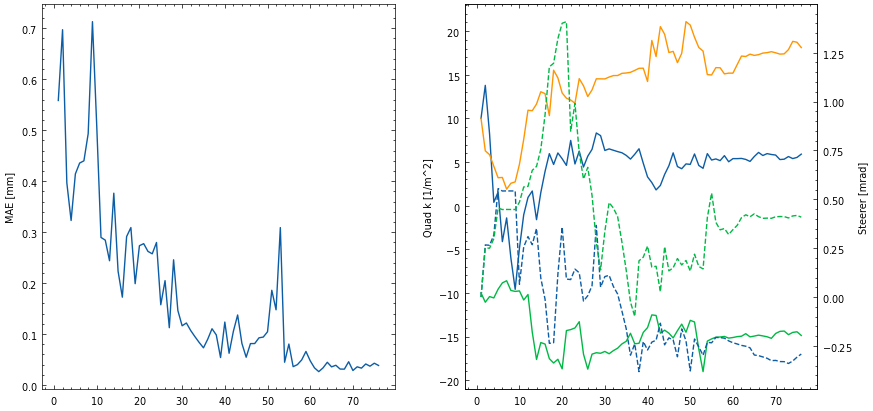

In [66]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[1]
ax2 = ax1.twinx()
for var in ["q1", "q2", "q3"]:
    ax1.plot(xopt_agent.xopt.data[var], label=var)
    ax1.set_ylabel("Quad k [1/m^2]")
for var in ["cv", "ch"]:
    ax2.plot(xopt_agent.xopt.data[var] * 1e3, ls="--", label=var)
    ax2.set_ylabel("Steerer [mrad]")


axes[0].plot(xopt_agent.xopt.data["mae"] * 1e3)
axes[0].set_ylabel("MAE [mm]")
best_mae = xopt_agent.xopt.data["mae"].min() * 1e3
print(f"Best MAE {best_mae:.3f} [mm]")


In [62]:
env.unwrapped.backend.get_beam_parameters()

array([-2.0121748e-05,  1.7275261e-04, -1.2940982e-06,  4.5585777e-05],
      dtype=float32)

## Test other generators


### Extremum Seeking


In [73]:
trial = trials[0]
method = "ES"
# Fast but local convergence
max_steps = 100
optimizer_kwargs = {
    "k": 2.0,
    "oscillation_size": 0.1,
    "decay_rate": 0.95,
}
# Slow but better convergence
# max_steps = 500
# optimizer_kwargs = {
#     "k": 2.0,
#     "oscillation_size": 0.1,
#     "decay_rate": 0.99,
# }


# Create the environment
env = ea.TransverseTuning(
    backend="cheetah",
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
    },
    action_mode="direct",
    magnet_init_mode=np.array([10, -10, 0, 10, 0]),
    target_beam_mode=trial.target_beam,
)
env = TimeLimit(env, max_steps)
env = TQDMWrapper(env)
# if callback is not None:
#     env = OptimizeFunctionCallback(env, callback)
# if data_log_dir is not None:
#     env = RecordEpisode(env, save_dir=data_log_dir)
# if logbook:
#     env = ARESEAeLog(env, model_name=model_name)

# env = RecordVideo(env, video_folder=f"recordings_real/{datetime.now():%Y%m%d%H%M}")

env = BOXoptCompatibleWrapper(env, prepare_ARES_EA_data)


vocs = VOCS(
    variables={
        "q1": [-72, 72],
        "q2": [-72, 72],
        "cv": [-6.1782e-3, 6.1782e-3],
        "q3": [-72, 72],
        "ch": [-6.1782e-3, 6.1782e-3],
    },
    # objectives={"mae": "MINIMIZE"},
    objectives={"logmae": "MINIMIZE"},
    # constraints={"max_pos": ["LESS_THAN", 2e-3], "max_size": ["LESS_THAN", 2e-3]},
    # constraints={"max_beamparam": ["LESS_THAN", 2e-3]},
)

xopt_agent = XoptAgent(
    env,
    vocs,
    method=method,
    action_order=["q1", "q2", "cv", "q3", "ch"],
    **optimizer_kwargs,
    # beta=2.0,
    # proximal_weights=0.2,
    # max_travel_distances=[stepsize] * 5,
    # init_samples=init_samples,
)

# Actual optimisation
output, info = env.reset()
init_magnet_values = env.unwrapped.backend.get_magnets()
init_sample = [
    {k: v for k, v in zip(["q1", "q2", "cv", "q3", "ch"], init_magnet_values)}
]
xopt_agent.add_data(pd.DataFrame(init_sample), output)
done = False
while not done:
    action = xopt_agent.predict(n_samples=1)
    output, reward, done, truncated, info = env.step(action)
    xopt_agent.add_data(xopt_agent.last_sample, output)


 99%|█████████▉| 99/100 [00:00<00:00, 496.81it/s]

In [74]:
xopt_agent.xopt.data

,q1,q2,cv,q3,ch,mae,logmae,max_beamparam
1,10.000000,-10.000000,0.000000,10.000000,0.000000,0.000558,-7.490718,0.001560
2,7.343069,-12.361165,-0.000147,6.618452,-0.000166,0.000223,-8.407952,0.000493
3,4.583583,-10.414948,-0.000004,2.805667,-0.000320,0.000286,-8.157975,0.000462
4,1.603748,-11.602957,-0.000026,-0.447928,-0.000519,0.000329,-8.019268,0.000950
5,0.360160,-14.385209,-0.000155,-0.511588,-0.000659,0.000532,-7.539557,0.001307
...,...,...,...,...,...,...,...,...
97,5.003848,-14.471083,-0.000227,14.775430,0.000363,0.000044,-10.039382,0.000096
98,4.989028,-14.449918,-0.000226,14.748307,0.000362,0.000045,-10.017607,0.000097
99,4.966643,-14.439849,-0.000224,14.717146,0.000361,0.000045,-10.007813,0.000099
100,4.943421,-14.441958,-0.000224,14.694813,0.000360,0.000045,-10.009473,0.000100


Best MAE 0.041 [mm]


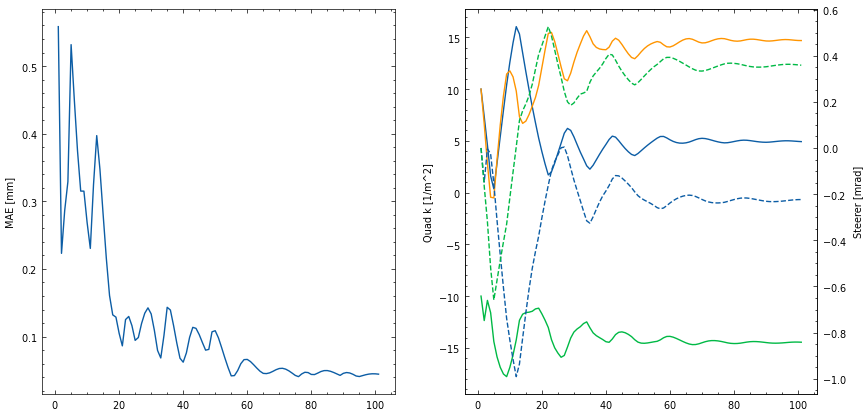

100%|██████████| 100/100 [00:19<00:00, 496.81it/s]

In [75]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[1]
ax2 = ax1.twinx()
for var in ["q1", "q2", "q3"]:
    ax1.plot(xopt_agent.xopt.data[var], label=var)
    ax1.set_ylabel("Quad k [1/m^2]")
for var in ["cv", "ch"]:
    ax2.plot(xopt_agent.xopt.data[var] * 1e3, ls="--", label=var)
    ax2.set_ylabel("Steerer [mrad]")


axes[0].plot(xopt_agent.xopt.data["mae"] * 1e3)
axes[0].set_ylabel("MAE [mm]")
best_mae = xopt_agent.xopt.data["mae"].min() * 1e3
print(f"Best MAE {best_mae:.3f} [mm]")


### RCDS


In [114]:
def rescale_magnet_values(
    magnet_values: np.ndarray,
    env: gym.Env,
    min_action: float = -1.0,
    max_action: float = 1.0,
):
    low = env.unwrapped.action_space.low
    high = env.unwrapped.action_space.high
    action = min_action + (max_action - min_action) * (magnet_values - low) / (
        high - low
    )
    return action


In [ ]:
trial = trials[0]
method = "RCDS"
# Fast but local convergence
max_steps = 400
optimizer_kwargs = {
    "noise": 1e-4,
    "step": 1e-2,
    "tol": 1e-5,
}
# Slow but better convergence
# max_steps = 500
# optimizer_kwargs = {
#     "k": 2.0,
#     "oscillation_size": 0.1,
#     "decay_rate": 0.99,
# }


# Create the environment
env = ea.TransverseTuning(
    backend="cheetah",
    backend_args={
        "incoming_mode": trial.incoming_beam,
        "misalignment_mode": trial.misalignments,
    },
    action_mode="direct",
    magnet_init_mode=np.array([10, -10, 0, 10, 0]),
    target_beam_mode=trial.target_beam,
)
env = TimeLimit(env, max_steps)
env = TQDMWrapper(env)
# if callback is not None:
#     env = OptimizeFunctionCallback(env, callback)
# if data_log_dir is not None:
#     env = RecordEpisode(env, save_dir=data_log_dir)
# if logbook:
#     env = ARESEAeLog(env, model_name=model_name)

# env = RecordVideo(env, video_folder=f"recordings_real/{datetime.now():%Y%m%d%H%M}")
env = RescaleAction(env, -1, 1)
env = BOXoptCompatibleWrapper(env, prepare_ARES_EA_data)


vocs = VOCS(
    variables={
        "q1": [-1, 1],
        "q2": [-1, 1],
        "cv": [-1, 1],
        "q3": [-1, 1],
        "ch": [-1, 1],
    },
    # objectives={"mae": "MINIMIZE"},
    objectives={"logmae": "MINIMIZE"},
)

xopt_agent = XoptAgent(
    env,
    vocs,
    method=method,
    action_order=["q1", "q2", "cv", "q3", "ch"],
    **optimizer_kwargs,
)

# Actual optimisation
output, info = env.reset()
scaled_init_magnet_values = rescale_magnet_values(
    env.unwrapped.backend.get_magnets(), env.env
)
# init_magnet_values = env.env.backend.get_magnets()
init_sample = [
    {k: v for k, v in zip(["q1", "q2", "cv", "q3", "ch"], scaled_init_magnet_values)}
]
xopt_agent.add_data(pd.DataFrame(init_sample), output)
done = False
while not done:
    action = xopt_agent.predict(n_samples=1)
    output, reward, done, truncated, info = env.step(action)
    xopt_agent.add_data(xopt_agent.last_sample, output)


100%|██████████| 400/400 [00:25<00:00, 15.47it/s] 


























































Best MAE 0.075 [mm]


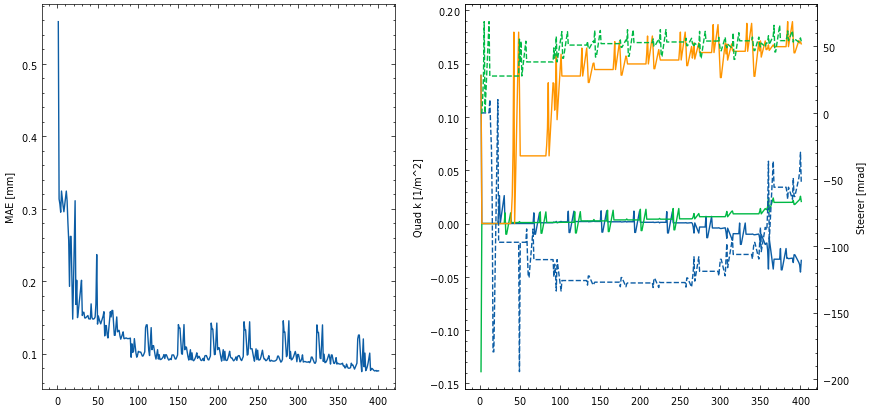

In [113]:
fig, axes = plt.subplots(1, 2, figsize=(10, 5))
ax1 = axes[1]
ax2 = ax1.twinx()
for var in ["q1", "q2", "q3"]:
    ax1.plot(xopt_agent.xopt.data[var], label=var)
    ax1.set_ylabel("Quad k [1/m^2]")
for var in ["cv", "ch"]:
    ax2.plot(xopt_agent.xopt.data[var] * 1e3, ls="--", label=var)
    ax2.set_ylabel("Steerer [mrad]")

axes[0].plot(xopt_agent.xopt.data["mae"] * 1e3)
axes[0].set_ylabel("MAE [mm]")
best_mae = xopt_agent.xopt.data["mae"].min() * 1e3
print(f"Best MAE {best_mae:.3f} [mm]")
